### This notebook shows how to use `scarlet` to deblend galaxies in HSC data
- Contact **Jiaxuan Li** via jiaxuanl@princeton.edu
- Requirements: you have to install [`sep`](https://sep.readthedocs.io/) (Python version of Source Extractor), [`scarlet`](https://github.com/pmelchior/scarlet) as well as [`kuaizi`](https://github.com/AstroJacobLi/kuaizi) (a collection of my own code snippets). Please contact me should you have any questions when installing these packages.
- Please also see the documentation of `scarlet` for more information.

In [3]:
# Import packages
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
#from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

plt.rcParams['font.size'] = 15
plt.rc('image', cmap='inferno', interpolation='none', origin='lower')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from kuaizi.detection import Data
#kz.utils.set_env(project='HSC', name='HSC_LSBG')
# kz.utils.set_matplotlib(usetex=False, fontsize=15)

## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi.task import hsc_cutout, hsc_psf

s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide')

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/s18a_wide/s18a_wide_tables.fits


In [4]:
if not os.path.isdir('./Images/'):
    os.mkdir('./Images/')
if not os.path.isdir('./PSFs/'):
    os.mkdir('./PSFs/')
if not os.path.isdir('./Models/'):
    os.mkdir('./Models/')

In [5]:
# Download images and PSFs from HSC database
prefix = 'blend'
index = 0
lsbg_coord = SkyCoord(ra=16.9681, dec=0.3566, unit='deg')

size_ang = 0.5 * u.arcmin
channels = 'griz'

cutout = hsc_cutout(
    lsbg_coord,
    cutout_size=size_ang,
    filters=channels,
    mask=True,
    variance=True,
    archive=s18a,
    use_saved=True,
    output_dir='./Images/',
    prefix=f'{prefix}_{index:04d}_img',
    save_output=True)
psf_list = hsc_psf(
    lsbg_coord,
    centered=True,
    filters=channels,
    img_type='coadd',
    verbose=True,
    archive=s18a,
    save_output=True,
    use_saved=True,
    prefix=f'{prefix}_{index:04d}_psf',
    output_dir='./PSFs/')

channels_list = list(channels)

# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z']
# Read in saved FITS file: ./Images/blend_0000_img_g.fits
# Read in saved FITS file: ./Images/blend_0000_img_r.fits
# Read in saved FITS file: ./Images/blend_0000_img_i.fits
# Read in saved FITS file: ./Images/blend_0000_img_z.fits
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z']
# Read in saved FITS file: ./PSFs/blend_0000_psf_g.fits
# Read in saved FITS file: ./PSFs/blend_0000_psf_r.fits
# Read in saved FITS file: ./PSFs/blend_0000_psf_i.fits
# Read in saved FITS file: ./PSFs/blend_0000_psf_z.fits


In [6]:
# Reconstructure data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = channels_list
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
data = Data(images=images, weights=weights, wcs=w, psfs=psfs, channels=channels)

In [7]:
pixel_scale = 0.168

In [8]:
gaia_cat, msk_star = kz.utils.gaia_star_mask(  # Generate a mask for GAIA bright stars
    data.images.mean(axis=0), # averaged image
    w,
    pixel_scale=0.168,
    gaia_bright=19.5,
    mask_a=694.7, 
    mask_b=3.8,
    factor_b=1.0,
    factor_f=0.6)

    3 stars from Gaia are masked!


    Detected 63 objects


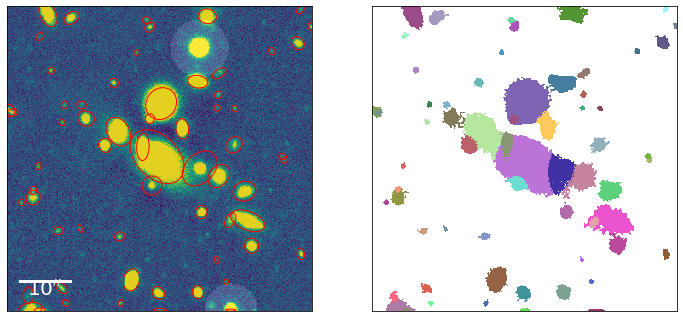

In [9]:
obj_cat_ori, segmap_ori, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=1.2,
    mask=msk_star,
    method='vanilla',
    convolve=False,
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=0.168,
    minarea=20,
    deblend_nthresh=64,
    deblend_cont=1e-3,
    sky_subtract=True)

catalog_c = SkyCoord(obj_cat_ori['ra'], obj_cat_ori['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_ori = obj_cat_ori[np.argsort(dist)[0]]['index']
cen_obj = obj_cat_ori[cen_indx_ori]
#print(f'# Central object is #{cen_indx_ori}.')
# Better position for cen_obj
x, y, _ = sep.winpos(data.images.mean(axis=0), cen_obj['x'], cen_obj['y'], 6)
ra, dec = data.wcs.wcs_pix2world(x, y, 0)
cen_obj['x'] = x
cen_obj['y'] = y
cen_obj['ra'] = ra
cen_obj['dec'] = dec

In [10]:
# Set weights of masked pixels to zero
for layer in data.weights:
    layer[msk_star.astype(bool)] = 0

(-0.5, 357.5, -0.5, 357.5)

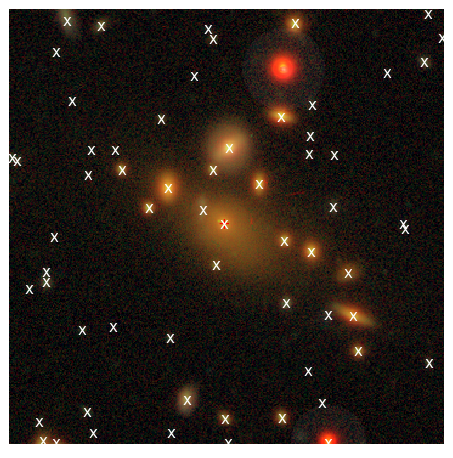

In [12]:
# Visualize our data
from scarlet.display import AsinhMapping

stretch = 2
Q = 8
img_rgb = scarlet.display.img_to_rgb(data.images, norm=AsinhMapping(minimum=-0.1, stretch=stretch, Q=Q))
weights = data.weights
mask = (np.sum(data.weights == 0, axis=0) != 0)

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img_rgb)
plt.imshow(mask.astype(float), origin='lower', alpha=0.05, cmap='Greys_r')

# Mark all of the sources from the detection cataog
plt.text(cen_obj["x"], cen_obj["y"], '+', color="red", horizontalalignment='center', verticalalignment='center')
for k, src in enumerate(obj_cat_ori):
    plt.text(src["x"], src["y"], 'x', color="w", horizontalalignment='center', verticalalignment='center') # src['index']

plt.axis('off')

In [13]:
# Construct `scarlet` frames and observation
from functools import partial
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(filters))
#model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=w, 
    psf=model_psf,
    channels=filters)
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=filters)
observation = observation.match(model_frame)

In [14]:
HSC_zeropoint = 27

In [16]:
sources = []

for k, src in enumerate(obj_cat_ori): #[np.where(sep2d > 2 * u.arcsec)[0]]
    if src['fwhm_custom'] > 15:
        new_source = scarlet.source.ExtendedSource(
            model_frame, (src['ra'], src['dec']), observation, thresh=3, K=2, shifting=True)
    elif src['fwhm_custom'] < 5:
        new_source = scarlet.source.CompactExtendedSource(
                model_frame, (src['ra'], src['dec']), observation)
    else:
       
        new_source = scarlet.source.SingleExtendedSource(
            model_frame, (src['ra'], src['dec']), observation, thresh=2, shifting=True)
    sources.append(new_source)


In [17]:
len(sources)

63

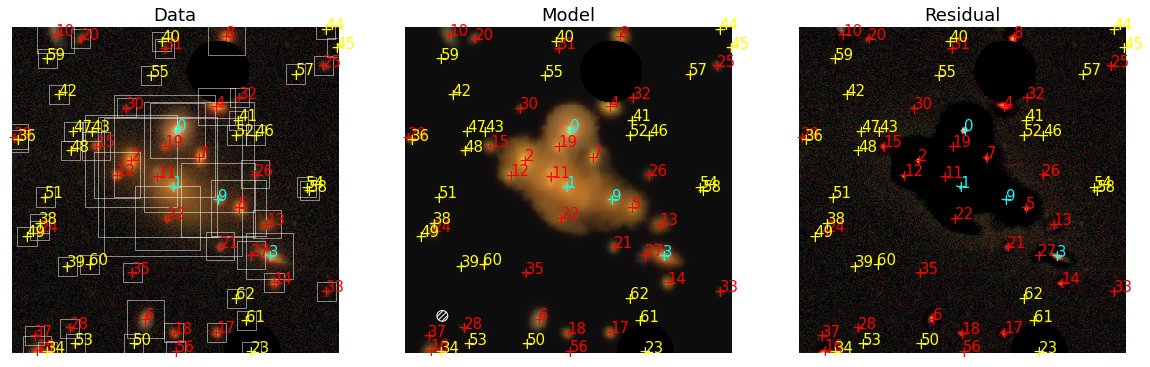

In [18]:
blend = scarlet.Blend(sources, observation)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
kz.display.display_scarlet_model(
    blend,
    ax=axes,
    #zoomin_size=40,
    minimum=-0.1,
    stretch=2,
    Q=8,
    add_boxes=True,
    scale_bar=False,
    channels=channels,
    show_mask=True,
    show_mark=True)

for ax in axes:
    ax.set_axis_off()

In [19]:
import dill, sys
sys.setrecursionlimit(10000)

In [20]:
%%time
blend.fit(150, 1e-4)
with open(f'./Models/{prefix}-{index}-trained-model.df', 'wb') as fp:
    dill.dump([blend, {'e_rel': 1e-4}], fp)
    fp.close()
last_loss = blend.loss[-1]
print(f'Succeed for e_rel = 1e-4 with {len(blend.loss)} iterations! Try higher accuracy!')

for i, e_rel in enumerate([5e-4, 1e-5, 1e-6]):
    blend.fit(150, e_rel)
    if len(blend.loss) > 20: # must have more than 20 iterations
        recent_loss = np.mean(blend.loss[-10:])
        min_loss = np.min(blend.loss[:-10])
        if recent_loss < min_loss:
            print(f'Succeed for e_rel = {e_rel} with {len(blend.loss)} iterations! Try higher accuracy!')
            with open(f'./Models/{prefix}-{index}-trained-model.df', 'wb') as fp:
                dill.dump([blend, {'e_rel': e_rel}], fp)
                fp.close()
        elif abs((recent_loss - min_loss) / min_loss) < 0.02:
            if recent_loss < last_loss: # better than the saved model
                print(f'I am okay with relative loss difference = {abs((recent_loss - min_loss) / min_loss)}. Fitting stopped.')
                with open(f'./Models/{prefix}-{index}-trained-model.df', 'wb') as fp:
                    dill.dump([blend, {'e_rel': e_rel}], fp)
                    fp.close()
                break
        else:
            print(f'Cannot achieve a global optimization with e_rel = {e_rel}.')

Succeed for e_rel = 1e-4 with 56 iterations! Try higher accuracy!
Succeed for e_rel = 0.0005 with 61 iterations! Try higher accuracy!
Succeed for e_rel = 1e-05 with 93 iterations! Try higher accuracy!
I am okay with relative loss difference = 0.00012225671250361216. Fitting stopped.
CPU times: user 1min 7s, sys: 3.11 s, total: 1min 10s
Wall time: 1min 11s


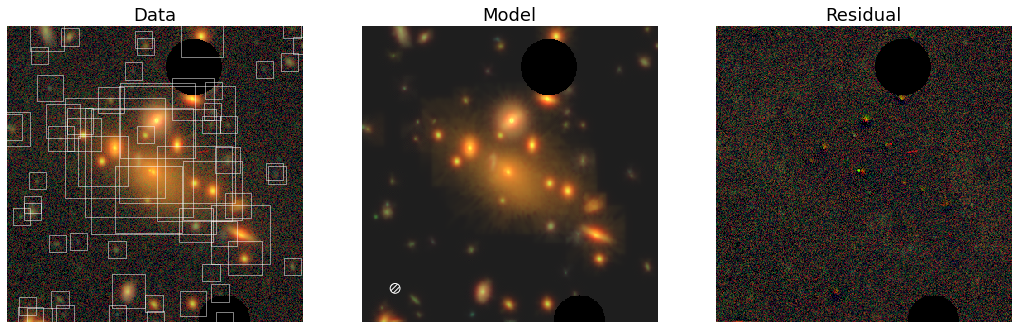

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

fig = kz.display.display_scarlet_model(
        blend,
        ax=axes,
        #show_ind=[1], only show which source
        #zoomin_size=60,
        minimum=-0.1,
        stretch=0.8,
        Q=8,
        channels='griz',
        show_loss=False,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

for ax in axes:
    ax.set_axis_off()
#plt.subplots_adjust(wspace=0.3)
#ax = axes[-1]

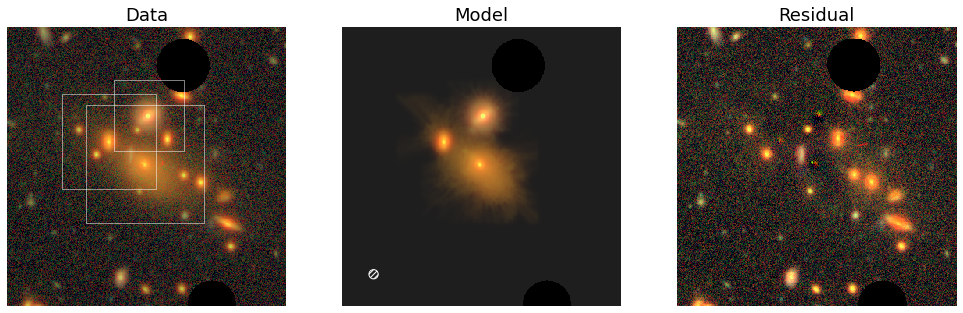

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(17, 6))

fig = kz.display.display_scarlet_model(
        blend,
        ax=axes,
        show_ind=[0, 1, 2],
        #zoomin_size=60,
        minimum=-0.1,
        stretch=0.8,
        Q=8,
        channels='griz',
        show_loss=False,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

for ax in axes:
    ax.set_axis_off()

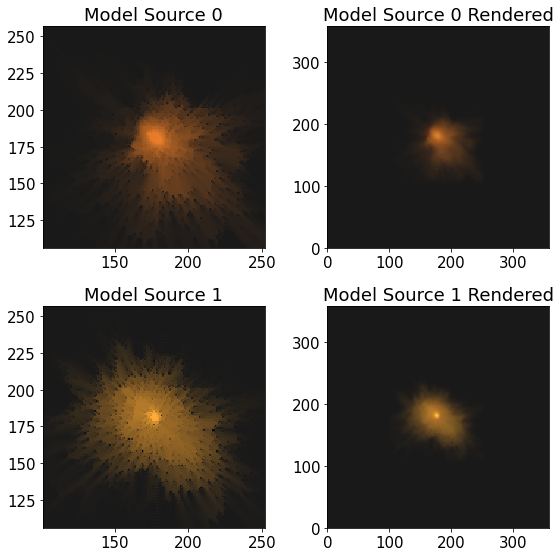

In [27]:
scarlet.display.show_sources(sources[1], norm=AsinhMapping(minimum=-0.1, stretch=1, Q=8), 
                             observation=observation, show_rendered=True, show_spectrum=False);

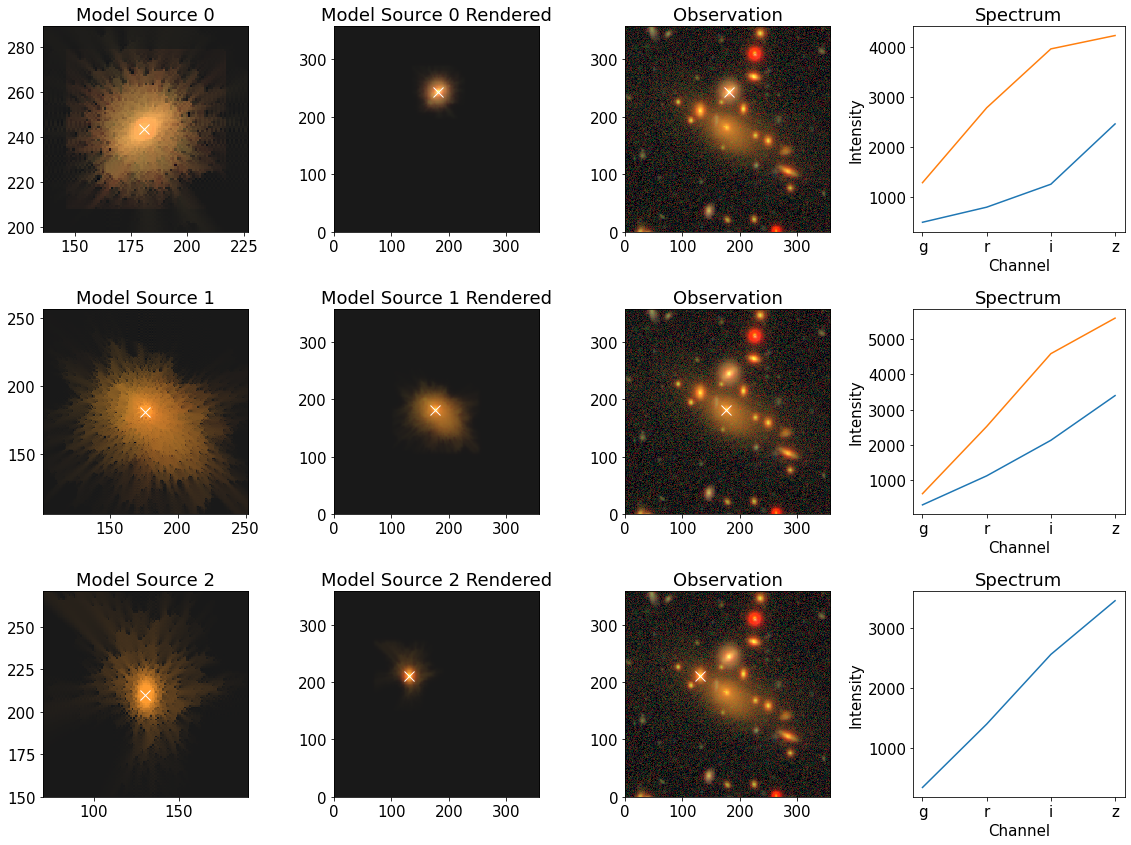

In [28]:
scarlet.display.show_sources(sources[0:3], norm=AsinhMapping(minimum=-0.1, stretch=1, Q=8), 
                             observation=observation, show_rendered=True, show_observed=True)
plt.show()